# This notebook is to compute linear receptive field

In [1]:
JSON_FILE_IDX = 0   # 0, 2, 4, 8, (9)

In [2]:
SAVE_TO_HDF5 = 0
SAVE_SUMMARY = 0

## 1. setup

In [3]:
import os
import sys
sys.path.append('../')
home_dir = '/Users'
proj_dir = home_dir + '/dlee/imaging/'
ext_dir = proj_dir + 'data-extract/'

In [4]:
import numpy as np
import scipy.io
import scipy.signal
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.spiketools as spk
import pyret.nonlinearities as nl
import utils
import stats

## 2. Load .json file

In [5]:
json_file_list = ['0.json', '1.json', '2.json',              # 23-06-16    
                  '3.json', '4.json',                        # 23-06-20
                  '5.json', '6.json', '7.json', '8.json',    # 23-06-26
                  '9.json']                                  # 23-06-26 sort2
n_sess = len(json_file_list)

In [6]:
jsl = {}
for j in range(n_sess):
    with open(proj_dir + 'json/' + json_file_list[j], 'r') as js:
        jsl[j] = json.load(js)
p = jsl[JSON_FILE_IDX]
print(jsl[0].keys())
print('total number of json files:', len(jsl))

dict_keys(['exp_id', 'exp_date', 'exp_session', 'roi_trace', 'roi_snap', 'p', 'pd_trace', 'pd_threshold', 'cc', 'loc', 'wn', 'nm', 'zoom', 'laser_percent', 'GCL', 'INL', 'flipTime', 'test_repeat', 'test_seed', 'test_fr', 'test_totalFrame', 'test_totalFrame30', 'test_totalFrame60', 'test_box_size', 'train_repeat', 'train_seed', 'train_fr', 'train_totalFrame', 'train_totalFrame30', 'train_totalFrame60', 'train_box_size', 'roi_threshold', 'resp_idx', 'n_before', 'n_after', 'space_1_idx', 'space_2_idx', 'space_sigma', 'time_sigma'])
total number of json files: 10


## 3. Load .h5 file

In [7]:
h5_file_list = [str(jsl[j]['exp_id']) + '_' + jsl[j]['roi_trace'][:-14] + '.h5' for j in range(n_sess)]
h5_file_list

['0_23-06-16-loc1-wn.h5',
 '1_23-06-16-loc2-nm.h5',
 '2_23-06-16-loc3-wn.h5',
 '3_23-06-20-loc3-nm.h5',
 '4_23-06-20-loc4-wn.h5',
 '5_23-06-26-loc1-nm.h5',
 '6_23-06-26-loc2-nm.h5',
 '7_23-06-26-loc3-nm.h5',
 '8_23-06-26-loc3-wn.h5',
 '9_23-06-26-loc3-wn.h5']

In [8]:
ex = {}
with h5py.File(ext_dir + h5_file_list[JSON_FILE_IDX]) as f:
    ex['stim_tr'] = np.double(f['train/stim'])
    ex['resp_tr'] = np.double(f['train/resp'])
    ex['tbins_tr'] = np.double(f['train/tbins'])
    ex['jitter_tr'] = np.double(f['train/jitter'])
    ex['stim_te'] = np.double(f['test/stim'])
    ex['resp_te'] = np.double(f['test/resp'])
    ex['tbins_te'] = np.double(f['test/tbins'])
    ex['jitter_te'] = np.double(f['test/jitter'])
    ex['cc_te'] = np.double(f['test/cc'])

## 4. Compute receptive field

In [9]:
n_roi = ex['resp_tr'].shape[0]
n_roi

283

In [10]:
rc = np.stack([ft.revcorr(ex['stim_tr'][p['resp_idx'][0] + p['n_after']:p['resp_idx'][1] + p['n_after']], 
                          stats.normalize(utils.butter_lf(ex['resp_tr'][r, p['resp_idx'][0]:p['resp_idx'][1]], Wn_l=6.0, fs=30.0)), 
                          p['n_before'] + p['n_after'])[0] for r in range(n_roi)])
rc.shape

(283, 45, 32, 32)

In [11]:
rc_s = np.stack([ft.decompose(stats.normalize(ft.smooth(rc[r, :, p['space_1_idx'][0]:p['space_1_idx'][1], p['space_2_idx'][0]:p['space_2_idx'][1]], 
                                                        p['space_sigma'], p['time_sigma'])))[0] for r in range(n_roi)])                #space
rc_t = np.stack([ft.decompose(stats.normalize(ft.smooth(rc[r, :, p['space_1_idx'][0]:p['space_1_idx'][1], p['space_2_idx'][0]:p['space_2_idx'][1]], 
                                                        p['space_sigma'], p['time_sigma'])))[1] for r in range(n_roi)])                #time

In [12]:
for r in range(n_roi):
    if np.max(rc_s[r]) < -np.min(rc_s[r]):
        rc_s[r] = -rc_s[r]
        rc_t[r] = -rc_t[r]

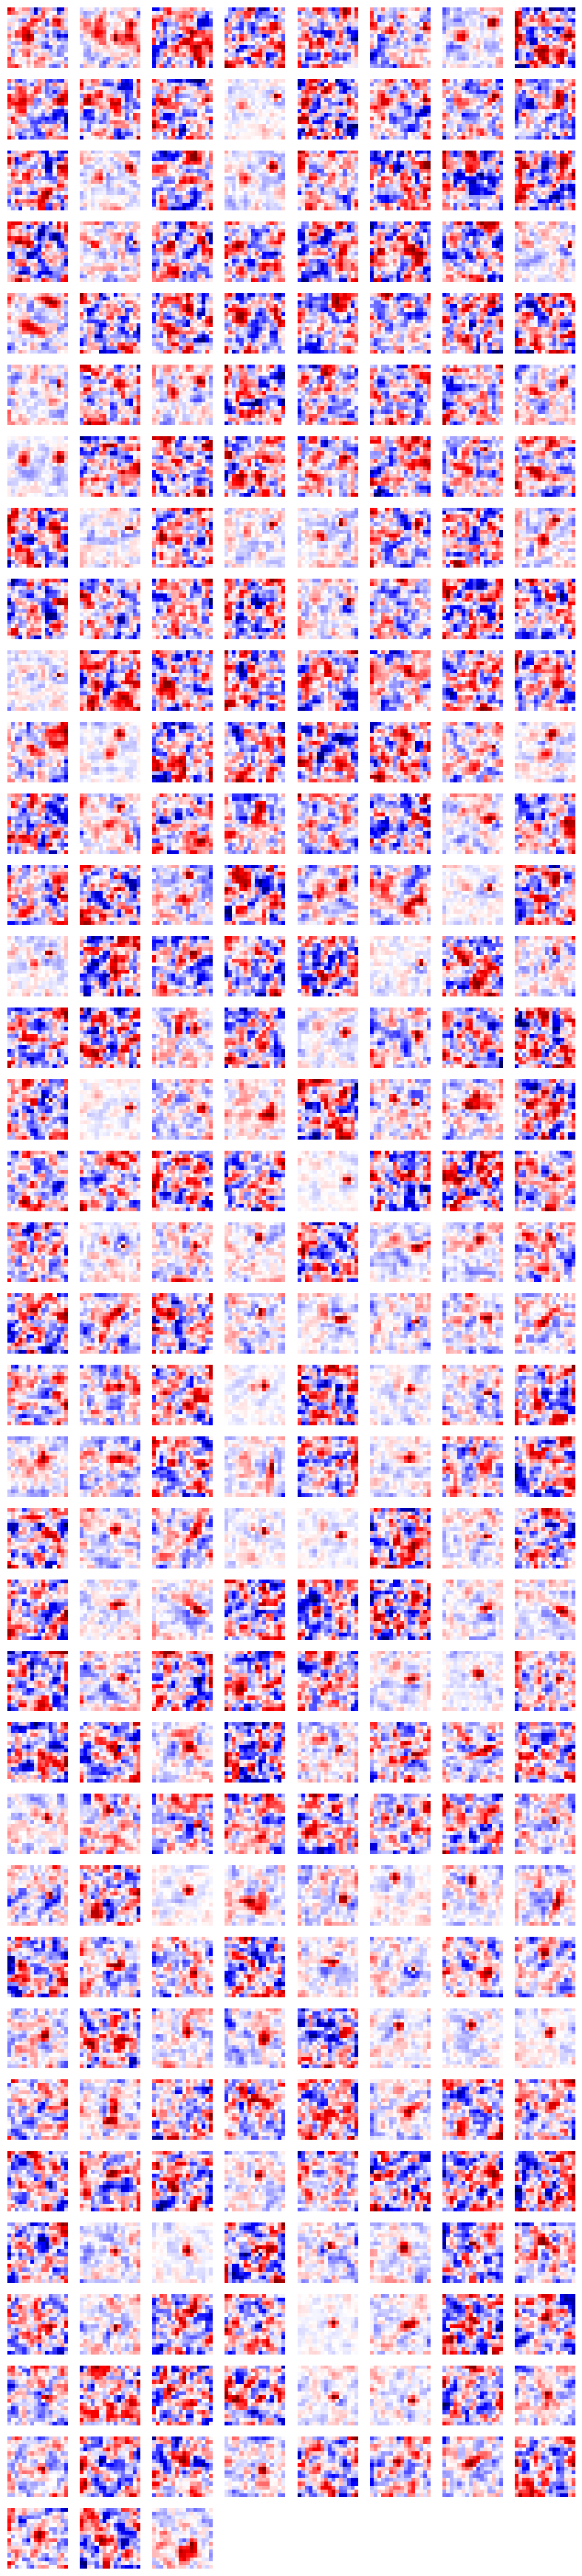

In [13]:
fig = plt.figure(figsize=(8, n_roi//8))
for i in range(n_roi):
    ax = plt.subplot((n_roi//8) + 1, 8, i + 1)
    ax.imshow(rc_s[i], cmap='seismic', 
              vmin=-np.max(abs(rc_s[i])), 
              vmax=np.max(abs(rc_s[i])),
              interpolation='nearest')
    ax.axis('off')
plt.tight_layout()

In [14]:
tbins_rc_t = np.arange(-(ex['tbins_tr'][1] * p['n_before']), 
                       ex['tbins_tr'][1] * p['n_after'], 
                       ex['tbins_tr'][1])[:p['n_before'] + p['n_after']]
tbins_rc_t.shape

(45,)

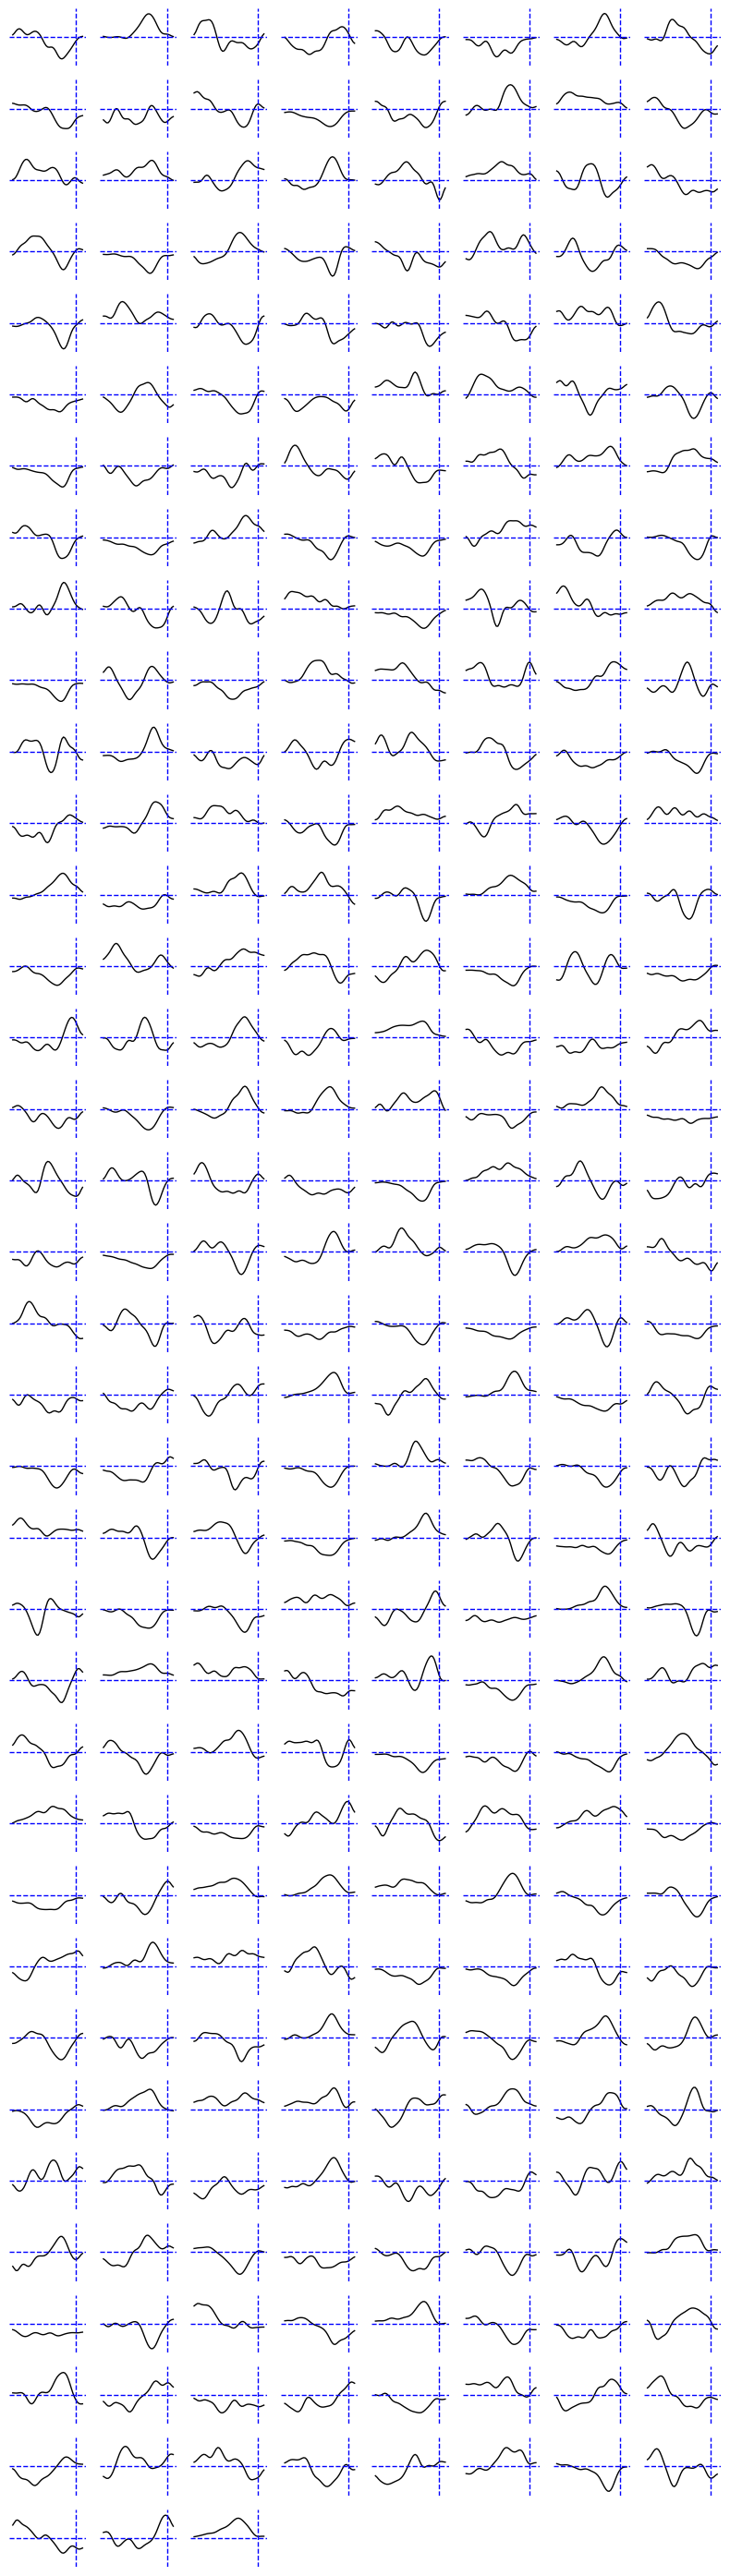

In [15]:
fig = plt.figure(figsize=(8, (n_roi//8)*0.8))
for i in range(n_roi):
    ax = plt.subplot((n_roi//8) + 1, 8, i + 1)
    ax.plot(tbins_rc_t[:], rc_t[i, :], linewidth=1, color='black')
    ax.axhline(y=0, color='blue', linewidth=1, linestyle='--')
    ax.axvline(x=0, color='blue', linewidth=1, linestyle='--')
    ax.set_ylim([-0.42, 0.42])
    ax.axis('off')
plt.tight_layout()

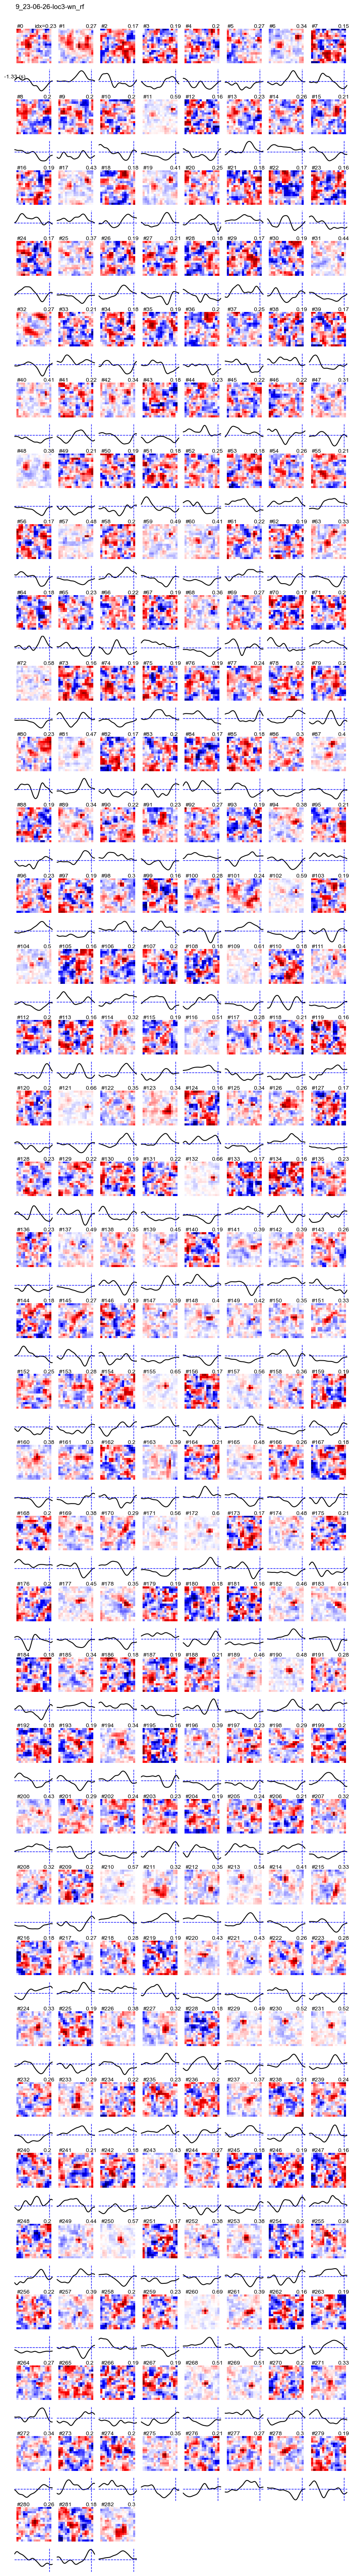

In [16]:
l = 9
plt.rcParams["font.family"] = "Arial"

fig = plt.figure(figsize=(l, (l/8)*((n_roi//8)+1) * 1.7))
fig.text(0.052, 0.957, str(p['exp_id']) + '_' + p['roi_trace'][:-14] + '_rf', fontsize=12)
gs = fig.add_gridspec(((n_roi//8) + 1) * 2, 8,  height_ratios=[1, 0.7] * ((n_roi//8) + 1),
                      left=0.05, right=0.95, bottom=0.05, top=0.95,
                      wspace=0.1, hspace=0.2)

for i in range(n_roi):
    ax = plt.subplot(gs[2*(i//8), np.mod(i, 8)])
    ax.imshow(rc_s[i], cmap='seismic', 
              vmin=-np.max(abs(rc_s[i])), 
              vmax=np.max(abs(rc_s[i])),
              interpolation='nearest')
    ax.text(-0.1, -1, '#' + str(i))
    if i == 0:
        ax.text(8, -1, 'idx=' + str(np.round(np.max(abs(rc_s), (1, 2))[i] * 100)/100))
    else:
        ax.text(12, -1, np.round(np.max(abs(rc_s), (1, 2))[i] * 100)/100)
        
    ax.axis('off')

for i in range(n_roi):
    ax = plt.subplot(gs[2*(i//8)+1, np.mod(i, 8)])
    ax.plot(tbins_rc_t[:], rc_t[i, :], color='black', linewidth=1.5)
    ax.axhline(y=0, color='blue', linewidth=1, linestyle='--')
    ax.axvline(x=0, color='blue', linewidth=1, linestyle='--')
    ax.set_ylim([rc_t.min()-0.01, rc_t.max()+0.01])
    ax.set_xlim([tbins_rc_t[0], tbins_rc_t[-1]])
    if i == 0:
        ax.text(tbins_rc_t[0] * 1.3, 0.1, str(np.round(tbins_rc_t[0] * 100)/100) + ' (s)') 
    ax.axis('off')

## 5. Linear prediction

In [17]:
X_tr = ex['stim_tr'][p['resp_idx'][0]:p['resp_idx'][1], p['space_1_idx'][0]:p['space_1_idx'][1], p['space_2_idx'][0]:p['space_2_idx'][1]]
y_tr = np.stack([stats.normalize(utils.butter_lf(ex['resp_tr'][r, :], Wn_l=6.0, fs=30.0)) 
                 for r in range(n_roi)])[:, p['resp_idx'][0]:p['resp_idx'][1]]
tbins_tr = ex['tbins_tr'][p['resp_idx'][0]:p['resp_idx'][1]]
f_ln = np.stack([stats.normalize(ft.lowranksta(ft.smooth(rc[r, :], p['space_sigma'], p['time_sigma']), k=2)[0]) 
                 for r in range(n_roi)])[:, :-p['n_after'], p['space_1_idx'][0]:p['space_1_idx'][1], p['space_2_idx'][0]:p['space_2_idx'][1]][:, ::-1, :, :]
if p['test_repeat'] > 0:
    X_te = ex['stim_te'][:, p['space_1_idx'][0]:p['space_1_idx'][1], p['space_2_idx'][0]:p['space_2_idx'][1]]
    y_te_trial = np.stack([np.stack([stats.normalize(utils.butter_lf(ex['resp_te'][t, r, :], Wn_l=6.0)) 
                                     for r in range(n_roi)]) for t in range(p['test_repeat'])])
    y_te = np.stack([stats.normalize(np.nanmean(y_te_trial, 0)[r, :]) for r in range(n_roi)])
    tbins_te = ex['tbins_te']
else:
    X_te = ex['stim_tr'][450:p['resp_idx'][0] - 150, p['space_1_idx'][0]:p['space_1_idx'][1], p['space_2_idx'][0]:p['space_2_idx'][1]]
    y_te = np.stack([stats.normalize(utils.butter_lf(ex['resp_tr'][r, :], Wn_l=6.0, fs=30.0)) for r in range(n_roi)])[:, 450:p['resp_idx'][0] - 150]
    tbins_te = ex['tbins_tr'][450:p['resp_idx'][0] - 150]
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, f_ln.shape

((53200, 16, 16), (283, 53200), (1750, 16, 16), (283, 1750), (283, 40, 16, 16))

In [18]:
lp_tr = np.stack([stats.normalize(ft.linear_response(stats.normalize(f_ln[r, :]), X_tr)) for r in range(n_roi)])
lp_te = np.stack([stats.normalize(ft.linear_response(stats.normalize(f_ln[r, :]), X_te)) for r in range(n_roi)])
lp_tr.shape, lp_te.shape

((283, 53200), (283, 1750))

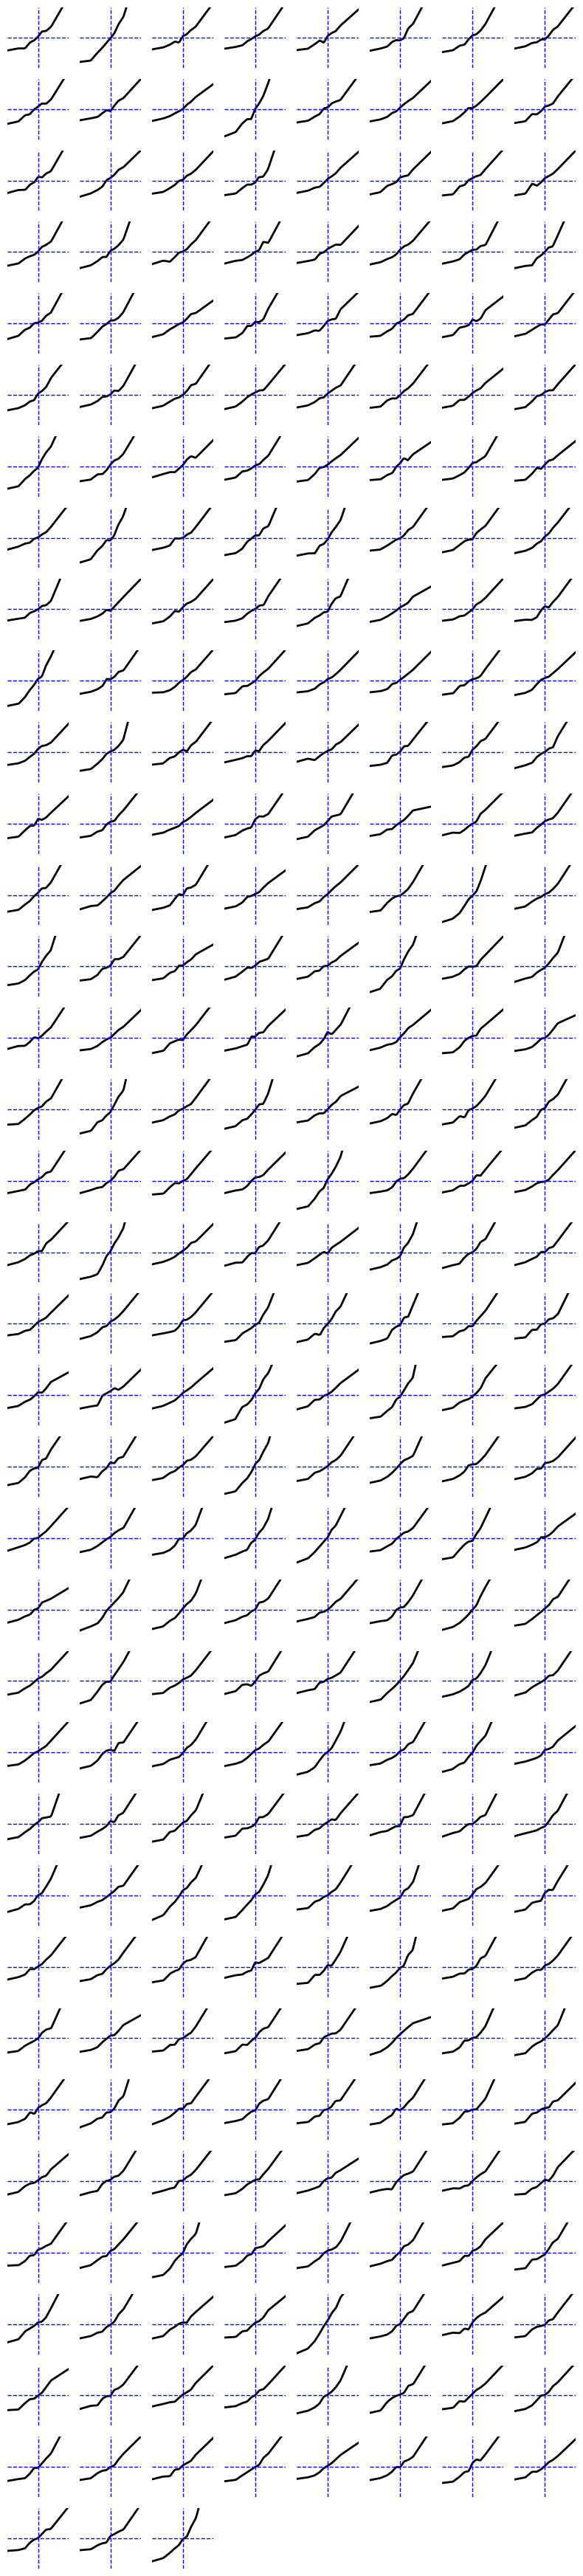

In [19]:
bt = {}
bt['model'] = []
y_tr_hat = np.zeros(lp_tr.shape)
y_te_hat = np.zeros(lp_te.shape)
nbins = 10

fig = plt.figure(figsize=(8, n_roi//8))
for r in range(n_roi):
    binterp = nl.Binterp(nbins)
    binterp.fit(lp_tr[r], y_tr[r])
    bt['model'].append(binterp)
    
    y_tr_hat[r] = binterp.predict(lp_tr[r])
    y_te_hat[r] = binterp.predict(lp_te[r])
    
    # plot
    ax = plt.subplot((n_roi//8)+1, 8, r+1)
    nonlin_range = (lp_tr[r].min(), lp_tr[r].max())
    binterp.plot(nonlin_range, linewidth=2, label='Binterp', color='black')
    ax.axhline(y=0, color='blue', linewidth=1, linestyle='--')
    ax.axvline(x=0, color='blue', linewidth=1, linestyle='--')
    ax.set_xlim([-2, 2])
    ax.set_ylim([-0.4, 0.4])
    ax.axis('off')
plt.tight_layout()

## 6. Result

In [20]:
cc_ln = np.stack([scipy.stats.pearsonr(y_te_hat[r], y_te[r])[0] for r in range(n_roi)])
#cc_p_ln = np.stack([scipy.stats.pearsonr(y_te_hat[r], y_te[r])[1] for r in range(n_roi)])
#cc_tr_ln = np.stack([scipy.stats.pearsonr(y_tr_hat[r], y_tr[r])[0] for r in range(n_roi)])
cc_ln.shape

(283,)

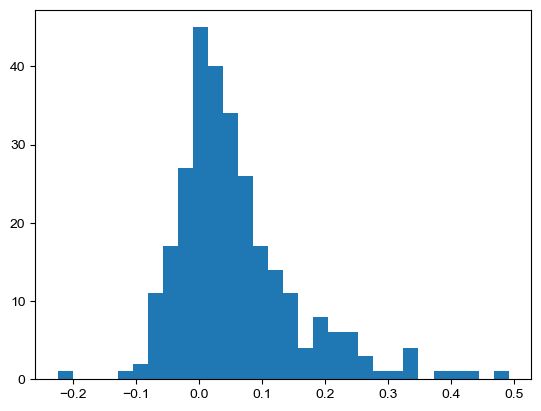

In [21]:
plt.hist(cc_ln, 30);

## 7. Save as h5 & pdf file

In [22]:
analysis_wn_dir = proj_dir + 'analysis-wn/'
analysis_wn_file = str(p['exp_id']) + '_' + p['roi_trace'][:-14] + '_rf.pdf'
analysis_wn_h5_file = str(p['exp_id']) + '_' + p['roi_trace'][:-14] + '_rf.h5'

In [23]:
if SAVE_TO_HDF5:
    with h5py.File(analysis_wn_dir + analysis_wn_h5_file, 'w') as f:
        f.create_dataset('train/stim', data=X_tr)
        f.create_dataset('train/resp', data=y_tr)
        f.create_dataset('train/tbins', data=tbins_tr)
        f.create_dataset('test/stim', data=X_te)
        f.create_dataset('test/resp', data=y_te)
        f.create_dataset('test/tbins', data=tbins_te)
        if p['test_repeat'] > 0:
            f.create_dataset('test/cc/mean', data=ex['cc_te'])
            f.create_dataset('test/cc/trial', data=stats.corr(y_te_trial.swapaxes(0, 1), mode='mean')[:, :, 0])
        else:
            f.create_dataset('test/cc/mean', data=np.nan)
            f.create_dataset('test/cc/trial', data=np.nan)
        f.create_dataset('result/ln/cc', data=cc_ln)
        f.create_dataset('result/ln/rfidx', data=np.max(abs(rc_s), (1, 2)))
        f.create_dataset('result/ln/rf', data=rc)

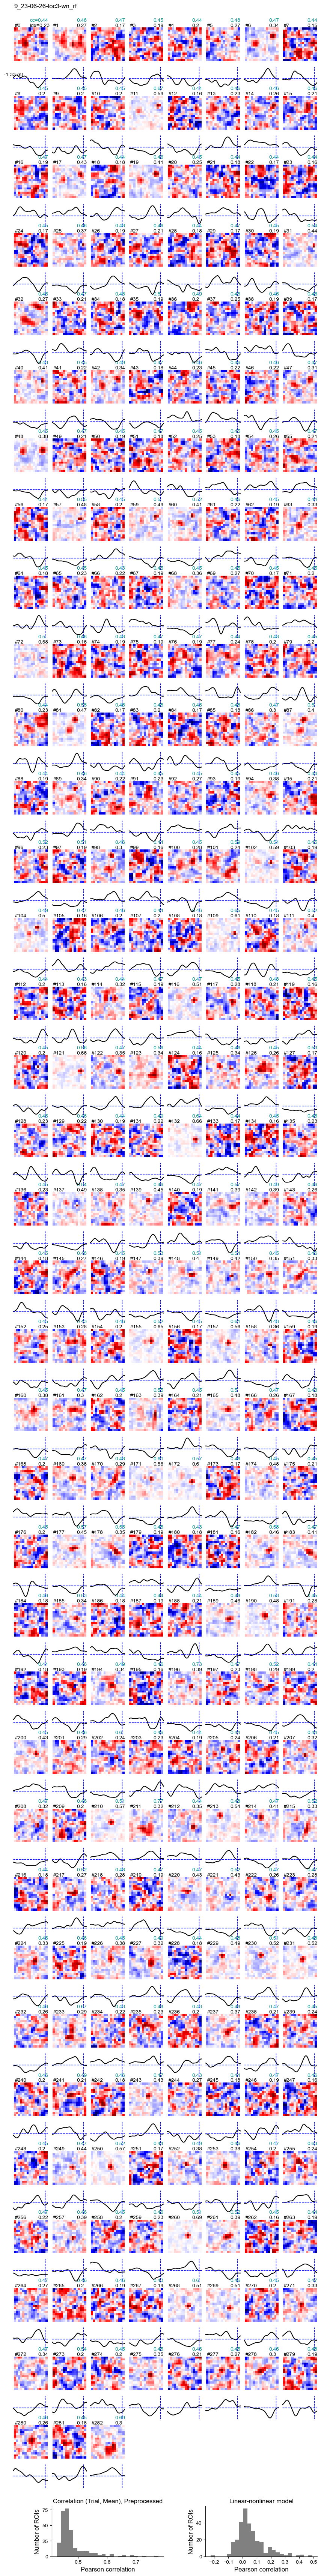

In [24]:
l = 9
plt.rcParams["font.family"] = "Arial"

fig = plt.figure(figsize=(l, (l/8)*((n_roi//8)+1+1) * 1.8))
fig.text(0.052, 0.957, str(p['exp_id']) + '_' + p['roi_trace'][:-14] + '_rf', fontsize=12)
gs = fig.add_gridspec(((n_roi//8) + 1) * 2 + 2, 8,  height_ratios=[1, 0.7] * ((n_roi//8) + 1) + [0.2, 1.5],
                      left=0.05, right=0.95, bottom=0.05, top=0.95,
                      wspace=0.1, hspace=0.2)

for i in range(n_roi):
    ax = plt.subplot(gs[2*(i//8), np.mod(i, 8)])
    ax.imshow(rc_s[i], cmap='seismic', 
              vmin=-np.max(abs(rc_s[i])), 
              vmax=np.max(abs(rc_s[i])),
              interpolation='nearest')
    ax.text(-0.1, -1, '#' + str(i))
    if i == 0:
        ax.text(7, -1, 'idx=' + str(np.round(np.max(abs(rc_s), (1, 2))[i] * 100)/100))
    else:
        ax.text(11, -1, np.round(np.max(abs(rc_s), (1, 2))[i] * 100)/100)
    
    if p['test_repeat'] > 0:
        if i == 0:
            ax.text(7, -3.5, 'cc=' + str(np.round(ex['cc_te'][i, 0] * 100)/100), color='darkcyan')
        else:
            ax.text(11, -3.5, np.round(ex['cc_te'][i, 0] * 100)/100, color='darkcyan')
    else:
        if i == 0:
            ax.text(8, -3.5, 'cc=N/A', color='darkcyan')
        #else:
            
    ax.axis('off')

for i in range(n_roi):
    ax = plt.subplot(gs[2*(i//8)+1, np.mod(i, 8)])
    ax.plot(tbins_rc_t[:], rc_t[i, :], color='black', linewidth=1.5)
    ax.axhline(y=0, color='blue', linewidth=1, linestyle='--')
    ax.axvline(x=0, color='blue', linewidth=1, linestyle='--')
    ax.set_ylim([rc_t.min()-0.02, rc_t.max()+0.02])
    ax.set_xlim([tbins_rc_t[0], tbins_rc_t[-1]])
    if i == 0:
        ax.text(tbins_rc_t[0] * 1.3, 0.1, str(np.round(tbins_rc_t[0] * 100)/100) + ' (s)') 
    ax.axis('off')


if p['test_repeat'] > 0:
    ax = plt.subplot(gs[-1:, 1:4])
    ax.hist(np.mean(stats.corr(y_te_trial.swapaxes(0, 1), mode='mean')[:, :, 0], 1), 25, color='gray')
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
    ax.set_xlabel('Pearson correlation', fontsize=12)
    ax.set_ylabel('Number of ROIs', fontsize=12)
    ax.set_title('Correlation (Trial, Mean), Preprocessed', fontsize=12)

ax = plt.subplot(gs[-1:, 5:])
ax.hist(cc_ln, 25, color='gray')
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=0.1))
ax.set_xlabel('Pearson correlation', fontsize=12)
ax.set_ylabel('Number of ROIs', fontsize=12)
ax.set_title('Linear-nonlinear model', fontsize=12)

if SAVE_SUMMARY:
    plt.savefig(analysis_wn_dir + analysis_wn_file, dpi=300, format='pdf', bbox_inches='tight')